In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.animation as animation

import scipy.signal as spsig
import scipy.ndimage as spimg
import h5py as h5
# import Pulse as pulse
import glob
import itertools as itools
import functools as ftools

# logging, flow control and optimization
from logzero import logger
import multiprocessing
from numba import jit as njit

# jwave imports
from jwave.geometry import Domain, Medium, TimeAxis, Sources, sphere_mask, circ_mask
import jax.numpy as jnp
from jax import jit
from jwave import FourierSeries
from jwave.utils import show_field
import jax

from jax import jit
from jax import numpy as jnp
from jaxdf import FourierSeries
from matplotlib import pyplot as plt

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *

import Pulse as pulse

# pyvista/meshing imports
import pyvista as pv

In [2]:
jax.config.update('jax_default_device', jax.devices('cpu')[0])
jax.config.update( 'jax_enable_x64', False )
%matplotlib widget

# User edit
You should not have to change anyting beyond the next cell. 

In [ ]:
############## user edit #######################

meshfile = './AcrylicWedge.stl'
maskfile = './BaselineHires3D.h5'
string_handle = 'Azimuthal'
padding_fraction = 0.1
num_points_along_largest_dimension = 400
pml_fraction = 0.5 # fraction of the buffer region outside the object used as PML

# # multiprocess parameters
# num_processes = 10

# can/cell details
soc = 0.3
can_thickness = 0.16
can_center = 21.5
transducer_dist = 10.
can_radius = 10.5
can_height = 70.
roll_inner_radius = 2.
cathode_location =  ( -135.+ ( TEMPLATE. / 18. ) * 90. )*np.pi/180. 
cathode_thickness = 0.13 
cathode_wrapping_sense = 1.
crack_edge_dist=-15.*np.pi/180.
anode_thickness=0.16
crack_width=0.5 / can_radius # i.e., 500 um in radians
add_crack=True 

# Material properties (reference: https://www.sciencedirect.com/science/article/pii/S2352152X22006016)
# NOTE: Core is a fictitious material with the same acoustic impedance of air. 
# NOTE: water properties is substituted for electrolyte for now. 
materials = [ 'steel', 'oil', 'roll', 'anode', 'electrolyte', 'cathode', 'core' ]
speeds = [ 5500., 1440., 1041.865, (1.-soc)*1341. + soc*1443., 1497., (1.-soc)*1093. + soc*1136., 3410. ]
densities = [ 7850., 870., 1933.949, (1.-soc)*1909. + soc*1994., 1000., (1.-soc)*4172. + soc*3848., 0.129 ] # jelly roll parameters for SOC = 0.3

# pulse characteristics
input_pulse_file = '/home/smaddali/simulations/input_signal.csv'
center_frequency = 5.e6 # Hz
pulse_hg_order = 3 # order of the Hermite-Gauss pulse
simulation_time = 32.e-6 
c_mult = 0.05   # multiplier for max. Courant factor, to prevent diverging simulation. 

# azimuthal source details (this is a line source)
x_loc1 = [ -15., 5. ] # range of line source
y_loc1 = -11. 
# n_oscillators = 35

# axial source details (focus)
y_loc2, z_loc2 = -11., 10.
focal_length = 11.
num_elements = 32
element_separation = 0.3 # mm in Y

# display/visualization parameters
csf = 2. # color scale factor
frame_skip = 5

################################################

# Stop!
Don't edit anything beyond this cell, unless you know what you're doing. 

# Acoustic impedance and reflectivity

In [4]:
list( itools.combinations( materials, 2 )  )

[('steel', 'oil'),
 ('steel', 'roll'),
 ('steel', 'anode'),
 ('steel', 'electrolyte'),
 ('steel', 'cathode'),
 ('steel', 'core'),
 ('oil', 'roll'),
 ('oil', 'anode'),
 ('oil', 'electrolyte'),
 ('oil', 'cathode'),
 ('oil', 'core'),
 ('roll', 'anode'),
 ('roll', 'electrolyte'),
 ('roll', 'cathode'),
 ('roll', 'core'),
 ('anode', 'electrolyte'),
 ('anode', 'cathode'),
 ('anode', 'core'),
 ('electrolyte', 'cathode'),
 ('electrolyte', 'core'),
 ('cathode', 'core')]

In [5]:
material_properties = { key: [ val1, val2 ] for key, val1, val2 in zip( materials, speeds, densities ) }
reflectivity = { 
    key: ( np.prod( material_properties[ key[0] ] ) - np.prod( material_properties[ key[1] ] ) ) / ( np.prod( material_properties[ key[0] ] ) + np.prod( material_properties[ key[1] ] ) )
    for key in list( itools.combinations( materials, 2 ) )
}

In [6]:
material_properties

{'steel': [5500.0, 7850.0],
 'oil': [1440.0, 870.0],
 'roll': [1041.865, 1933.949],
 'anode': [1371.6, 1934.5],
 'electrolyte': [1497.0, 1000.0],
 'cathode': [1105.8999999999999, 4074.7999999999993],
 'core': [3410.0, 0.129]}

In [7]:
reflectivity

{('steel', 'oil'): 0.9436028792782897,
 ('steel', 'roll'): 0.9108246240556087,
 ('steel', 'anode'): 0.8842044450894404,
 ('steel', 'electrolyte'): 0.9329781518624641,
 ('steel', 'cathode'): 0.8109816928202526,
 ('steel', 'core'): 0.9999796231375466,
 ('oil', 'roll'): -0.23322537632960863,
 ('oil', 'anode'): -0.3585516538722605,
 ('oil', 'electrolyte'): -0.0888064586515383,
 ('oil', 'cathode'): -0.5649336312297029,
 ('oil', 'core'): 0.9992979955338002,
 ('roll', 'anode'): -0.13676284394399266,
 ('roll', 'electrolyte'): 0.14747337437177244,
 ('roll', 'cathode'): -0.3820453501314744,
 ('roll', 'core'): 0.999563461234954,
 ('anode', 'electrolyte'): 0.27861682945012817,
 ('anode', 'cathode'): -0.2588049642744443,
 ('anode', 'core'): 0.9996684829413808,
 ('electrolyte', 'cathode'): -0.5012760702937019,
 ('electrolyte', 'core'): 0.9994124772514242,
 ('cathode', 'core'): 0.9998047866396721}

In [8]:
reference_material = 'roll'

# Grid details

In [9]:
buffer = 1. + padding_fraction
x_grid = buffer * np.linspace( -can_radius, can_radius, num_points_along_largest_dimension )
dx = ( x_grid[1:] - x_grid[:-1] ).mean()
y_grid = np.arange( -buffer*( can_radius + transducer_dist ), 0., dx )
grid_ranges = [ x_grid,  y_grid ]
shp = ( grid_ranges[1].size, grid_ranges[0].size )
dy = ( y_grid[1:] - y_grid[:-1] ).mean() # y dimension is longer because of line source location
grid = np.meshgrid( x_grid,  y_grid )
dx_final = [ dx, dy ]
logger.info( f'Simulation domain size: {grid[0].shape}' )
logger.info( f'Pixel size: {dx_final} mm' )

pts = np.concatenate( [ ar.ravel()[np.newaxis,:] for ar in grid ], axis=0 )

rho = np.sqrt( ( pts**2 ).sum( axis=0 ) )
im_azim = np.logical_and( rho <= can_radius, rho > can_radius - can_thickness ).reshape( shp )
im_azim = im_azim + 2.*np.logical_and( rho <= can_radius-can_thickness, rho >= can_radius-can_thickness-anode_thickness ).reshape( shp )

R = np.array( [ [ np.cos( cathode_location ), np.sin( cathode_location ) ], [ np.cos( np.pi/2. + cathode_location ), np.sin( np.pi/2. + cathode_location ) ] ] )
# pts_relative = pts[:2,:] # get 2D points
# pts_relative[-1,:] = pts_relative[-1,:] - center
# pts_relative = pts_relative.T # make this a 2xN array
pts_proj = R @ pts
theta = np.arctan2( pts_proj[1], pts_proj[0] ) # canonical range from -pi to pi

air_core = rho < roll_inner_radius
inside_roll = ftools.reduce( 
    np.logical_and, 
    [
        rho < can_radius - can_thickness - anode_thickness, 
        rho >= roll_inner_radius
    ]
)
cathode_segment = ftools.reduce( 
    np.logical_and, 
    [ 
        inside_roll,
        pts_proj[0] < can_radius - ( can_thickness + anode_thickness + cathode_thickness ), 
    ]
)
jelly_roll = ftools.reduce( 
    np.logical_or, 
    [ 
        cathode_segment, 
        np.logical_and( np.sign( theta )==1, inside_roll )
    ]
)

cathode_air_gap = ftools.reduce( 
    np.logical_and, 
    [ 
        rho <= can_radius - ( can_thickness + anode_thickness ), 
        rho >= roll_inner_radius, 
        np.logical_not( np.logical_and( jelly_roll, inside_roll ) )
    ]
)
crack = ftools.reduce( 
    np.logical_and, 
    [ 
        rho <= can_radius - can_thickness, 
        rho >= can_radius - ( can_thickness + anode_thickness ), 
        theta >= crack_edge_dist - crack_width/2., # this theta is relative to the cathode edge, lab frame zero 
        theta <= crack_edge_dist + crack_width/2., 
    ]
)
electrolyte_fill_region = np.logical_or( cathode_air_gap, crack ) if add_crack else cathode_air_gap
efr = electrolyte_fill_region.reshape( shp )
im_azim = im_azim * np.logical_not( efr )

theta[ np.where( theta < 0. ) ] = theta[ np.where( theta < 0. ) ] + 2.*np.pi
cathode_arc = ftools.reduce( 
    np.logical_and, 
    [ 
        rho >= can_radius - ( can_thickness + anode_thickness + cathode_thickness ), 
        rho <= can_radius - ( can_thickness + anode_thickness ), 
        theta >= 0., 
        theta <= 3.*np.pi/2. 
    ]
)
jelly_roll = np.logical_and( jelly_roll, np.logical_not( cathode_arc ) )
mx =  im_azim.max()
im_azim = im_azim + ftools.reduce( 
    lambda x, y: x+y, 
    [ 
        ( n+mx+1 )*arr.reshape( grid_ranges[1].size, grid_ranges[0].size )
        for n, arr in enumerate( [ jelly_roll, cathode_arc, electrolyte_fill_region, air_core ] )
    ]
)
medium_dict = { 0:'oil', 1:'steel', 2:'anode', 3:'roll', 4:'cathode', 5:'electrolyte', 6:'core' }

2025-05-21 12:22:56 - jwave [INFO]: Simulation domain size: (390, 400)
2025-05-21 12:22:56 - jwave [INFO]: Pixel size: [0.05789473684210527, 0.05789473684210478] mm


In [10]:
# # rough calculation of cathode thickness from segmented image
# temp = np.array( 
#     [ 
#         [ 972., 246. ], 
#         [ 976., 241. ] 
#     ]
# )
# 0.019 * np.sqrt( ( np.diff( temp, axis=0 )**2 ).sum() )

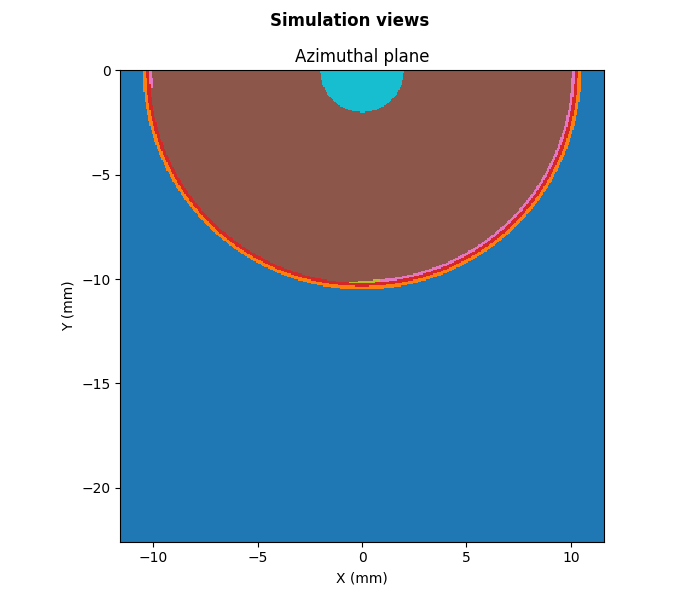

In [ ]:
fig = plt.figure( figsize=( 7, 6 ) )
ax = fig.subplots()
my_cmap = 'tab10'

ax.pcolormesh( grid_ranges[0], grid_ranges[1], im_azim, cmap=my_cmap ) #, alpha=0.5 )
ax.set_xlabel( 'X (mm)' )
ax.set_ylabel( 'Y (mm)' )
zoom_region = ptch.Rectangle( 
    # ( 4.5, -10 ), 
    ( -3., -13. ), 
    5., 
    5., 
    linewidth=2, 
    edgecolor='black', 
    facecolor='none', 
    label='zoom region'
)

ax.axis( 'tight' )
ax.set_title( f'Azimuthal plane' )

# ax.add_patch( zoom_region )
# ax_ins = ax.inset_axes( [ 0.6, 0.05, 0.35, 0.35 ] )
# # ax_ins = ax.inset_axes( [ 0.45, 0.45, 0.2, 0.2 ] )
# ax_ins.pcolormesh( grid_ranges[0], grid_ranges[1], im_azim, cmap=my_cmap )#, alpha=0.5 )
# # ax_ins.set_xlim( [ 4.5, 8 ] )
# # ax_ins.set_ylim( [ -10, -6.5 ] )
# ax_ins.set_xlim( [ -3., 3. ] )
# ax_ins.set_ylim( [ -13., -7. ] )
# ax_ins.set_xticks( [] )
# ax_ins.set_yticks( [] )
plt.suptitle( 'Simulation views', weight='bold' )
plt.gca().set_aspect( 'equal' )
plt.tight_layout()

plt.savefig( 'SimulationDomain_TEMPLATE.png' )


# `jwave` definitions

## Cross section simulations

### Azimuthal

In [12]:
def get_medium_properties( im, medium_dict ):
    def get_region( in_data ):
        return ( in_data[0]==in_data[1] )*in_data[2]
    sound_speed_map = ftools.reduce( 
        lambda x, y: x + y, 
        [ 
            get_region( [ im, idx, material_properties[ medium_dict[ idx ] ][0] ] )
            for idx in np.unique( im )
        ]
    )
    density_map = ftools.reduce( 
        lambda x, y: x + y, 
        [ 
            get_region( [ im, idx, material_properties[ medium_dict[ idx ] ][1] ] )
            for idx in np.unique( im )
        ]
    )
    return sound_speed_map, density_map

pml_size = np.round( buffer / dx_final[0] ).astype( int )//2
logger.info( f'PML size: {pml_size} pixels. ' )
speed_map, density_map = get_medium_properties( im_azim, medium_dict )
dx = ( float( dx_final[1] )*1.e-3, float( dx_final[0] )*1.e-3 )
domain_azim = Domain( ( grid_ranges[1].size, grid_ranges[0].size ), dx )
speed_field = FourierSeries( jnp.expand_dims( speed_map, axis=-1 ), domain=domain_azim )
density_field = FourierSeries( jnp.expand_dims( density_map, axis=-1 ), domain=domain_azim )

medium = Medium(domain=domain_azim, sound_speed=speed_field, density=density_field, pml_size=int( pml_size ), attenuation=0.95 )

2025-05-21 12:22:56 - jwave [INFO]: PML size: 9 pixels. 


In [13]:
# show_field( speed_map )
# show_field( density_map )

## Time domain

2025-05-21 12:22:57 - jwave [INFO]: Dominant frequency: 5.000000e+06 Hz
2025-05-21 12:22:57 - jwave [INFO]: Dominant_wavelength: 2.08e-04 m
2025-05-21 12:22:57 - jwave [INFO]: Sample points per dominant wavelength: 3
2025-05-21 12:22:57 - jwave [INFO]: Dominant time period: 2.00e-07 sec
2025-05-21 12:22:57 - jwave [INFO]: Courant factor: 9.00e-02
2025-05-21 12:22:57 - jwave [INFO]: Time step: 9.47e-10 sec


Text(0.5, 1.0, 'Input pulse of fequency 5.00e+06 Hz')

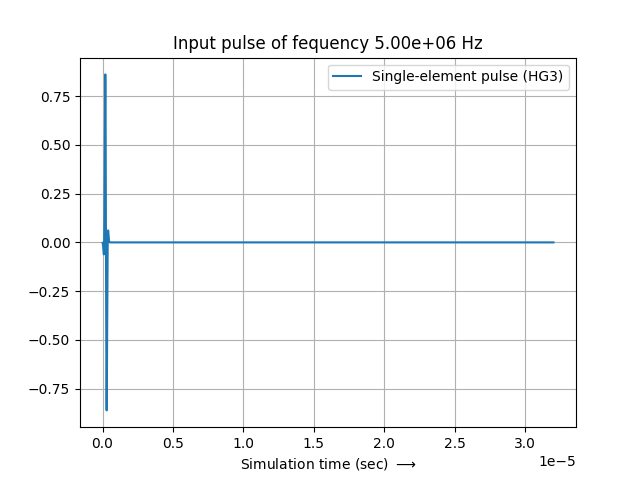

In [ ]:
# calculating time-domain characteristics of pulse
center_wavelength = material_properties[ reference_material ][0] / center_frequency # pulse wavelength
period = 1. / center_frequency 
dx_dv_largest = dx_final[0]*1.e-3/ min( [ prop[0] for _, prop in material_properties.items() ] )
cfl_max = 0.5 * period / dx_dv_largest # courant number
cfl = cfl_max * c_mult

# time axis object
time_axis = TimeAxis.from_medium( medium, cfl=cfl )
time_axis.t_end = simulation_time # this is all we are currently measuring

# pulse details
# input_pulse = pd.read_csv( input_pulse_file )


logger.info( f'Dominant frequency: {center_frequency:2e} Hz' )
logger.info( f'Dominant_wavelength: {center_wavelength:.2e} m' )
logger.info( f'Sample points per dominant wavelength: {int(center_wavelength/(dx_final[0]*1.e-3))}' )
logger.info( f'Dominant time period: {period:.2e} sec' )
logger.info( f'Courant factor: {cfl:.2e}' )
logger.info( f'Time step: {time_axis.dt:.2e} sec' )

# craft the pulse of appropriate central frequency by modifying the frequency of a dummy pulse
spread = 5.e-6
test_grid = np.linspace( -5.*spread, 5.*spread, 600 )
init = pulse.HermiteGauss( test_grid, 0., spread, pulse_hg_order )
peaks = spsig.find_peaks( init )[0] # peak locations only 
T = ( test_grid[peaks[1:]] - test_grid[peaks[:-1]] ).mean() # approx. oscillation period of oscillating pulse
new_spread = spread * ( period / T ) # this is the correct HG input parameter for the desired ultrasound pulse frequency

t = np.arange( 0., float( time_axis.t_end ), float( time_axis.dt ) )
init = pulse.HermiteGauss( t, 3*new_spread, new_spread, pulse_hg_order )

plt.figure()
plt.plot( t, init, label=f'Single-element pulse (HG{pulse_hg_order})' )
plt.xlabel( 'Simulation time (sec) $\\longrightarrow$' ) 
plt.legend()
plt.grid()
plt.title( f'Input pulse of fequency {center_frequency:.2e} Hz' )

# Run simulation

## Azimuthal

In [15]:
# xloc_w = np.linspace( x_loc1[0], x_loc1[1], n_oscillators )
# xloc = np.unique( np.round( grid_ranges[0].size * ( xloc_w - grid_ranges[0].min() ) / ( grid_ranges[0].max() - grid_ranges[0].min() ) ).astype( int ) )

xloc = list( np.where( np.abs( grid_ranges[0] ) <= 5. )[0] ) # for a 10 mm source
yloc = [ np.argmin( np.abs( grid_ranges[1] + 20. ) ) ] * len( xloc )
# print( xloc, yloc )

sources = Sources( 
    positions=( yloc, xloc ), 
    signals=jnp.stack( [ init ]*len( yloc ) ),
    dt=time_axis.dt, 
    domain=domain_azim
)

In [16]:
@jit
def compiled_simulator( sources ):
    return simulate_wave_propagation( medium, time_axis, sources=sources )

In [17]:
pressure = compiled_simulator( sources )
pres = np.squeeze( pressure.on_grid )
logger.info( f'Simulation size: {pres.shape}' )
pmax = min( np.abs( pres.min() ), np.abs( pres.max() ) )
pmin = -pmax

2025-05-21 12:22:59 - jwave [INFO]: Simulation size: (33786, 390, 400)


In [18]:
print( pmin, pmax )

-1.7184514 1.7184514


In [ ]:
crack_size = int( crack_width*can_radius*1000. )
logger.info( f'Crack size: {crack_size} um' )
with h5.File( f'crack{crack_size}um/JRImmersion_linesource_thetascan_TEMPLATE.h5', 'w' ) as fid: 
# with h5.File( f'JRImmersion_headon_nocrack.h5', 'w' ) as fid: 
    fid.create_dataset( 'image', data=im_azim )
    fid.create_dataset( 'pressure', data=pres[::frame_skip,:,:] )
    for key, val in {
        # 'medium_dict':medium_dict,
        'x':grid_ranges[0], 
        'y':grid_ranges[1], 
        'xloc':xloc, 
        'yloc':yloc, 
        'my_cmap':my_cmap, 
        'pmin':pmin, 
        'pmax':pmax,
        'csf':csf, 
        't':t[::frame_skip], 
        'time_steps':t[::frame_skip].size, 
        'dt':time_axis.dt*frame_skip
    }.items():
        fid[ 'pressure' ].attrs[ key ] = val 
    for key, val in medium_dict.items(): 
        fid[ 'pressure' ].attrs[val] = key

2025-05-21 12:52:06 - jwave [INFO]: Crack size: 500 um


# Visualization

In [ ]:
# my_cmap='hot'
# fig = plt.figure( figsize=( 14, 5 ) )
# ax = fig.subplots( 1, 2 )
# ax[0].pcolormesh( np.arange( grid_ranges[0].size ), np.arange( grid_ranges[1].size ), im_azim, cmap=my_cmap, alpha=0.5 )
# fld = ax[0].imshow( pres[-1,:,:], origin='lower', cmap='seismic' )
# ax[0].plot( xloc, yloc, '^k', markersize=2, label='Source' )
# fld.set_clim( [ pmin/csf, pmax/csf ] )
# ax[0].axis( 'equal' )
# ax[0].axis( 'square' )
# titl = ax[0].set_title( 'Pressure wave at time step 0' )
# ax[0].legend()

# ax[1].plot( t/1.e-6, pres[:,yloc,xloc].sum( axis=1 ) )
# ax[1].axis( 'tight' )
# ax[1].grid()
# ax[1].set_title( '2D pulse echo signal' )
# plt.suptitle( f'{string_handle} wave profile ({center_frequency/1.e6} MHz pulse)', weight='bold' )


# plt.tight_layout()

# def animate( n ):
#     fld.set_data( pres[n,yloc,xloc].sum( axis=1 ) )
#     fld.set_clim( [ pmin/csf, pmax/csf ] )
#     titl.set_text( f'Pressure wave at time {(n*time_axis.dt/1.e-6):.2e} us' )
#     return fld,

# ani = animation.FuncAnimation( fig, animate, interval=10, frames=pres.shape[0], blit=False, repeat=False )
# plt.show()